# Example 4. Multi-Layer Perceptron for Binary Classification

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn import metrics

import matplotlib.pyplot as plt
from torchview import draw_graph
from IPython.display import clear_output, display

## 0. Toy Dataset Generation (The XOR Problem)

In [2]:
num_samples = 1000

xx, yy = torch.meshgrid(torch.linspace(-1, 1, 50), torch.linspace(-1, 1, 50), indexing='xy')

x_total = torch.randn(num_samples, 2)
t_total = torch.logical_xor(x_total[:, 0] > 0, x_total[:, 1] > 0).long()

dataset = TensorDataset(x_total, t_total)
train_set, val_set, test_set = random_split(dataset, lengths=[0.64, 0.16, 0.2])

Text(0, 0.5, '$x_{1}$')

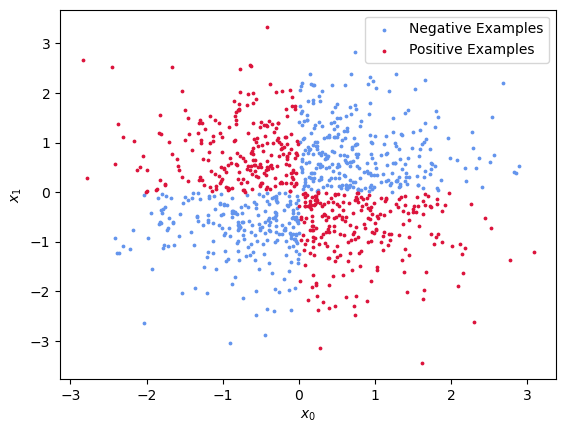

In [3]:
neg_mask = t_total == 0
pos_mask = t_total == 1

fig, ax = plt.subplots()
ax.scatter(x_total[neg_mask, 0], x_total[neg_mask, 1], s=3, label='Negative Examples', color='cornflowerblue')
ax.scatter(x_total[pos_mask, 0], x_total[pos_mask, 1], s=3, label='Positive Examples', color='crimson')
ax.legend()
ax.set_xlabel(r'$x_{0}$')
ax.set_ylabel(r'$x_{1}$')

## 1. Define a small MLP
- input layer to hidden layer of size 4
- ReLU activation
- hidden layer to output layer of size 1
- NO final sigmoid activation at the end for probability

We drop the last Sigmoid so the model outputs raw “logits,” and then use BCEWithLogitsLoss, which under the hood applies the Sigmoid and computes binary cross-entropy in one go. This fused operation is both more numerically stable (it avoids extreme values from separately squashing and then logging) and slightly more efficient than doing Sigmoid + BCELoss by hand.

In [4]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=4, bias=True),  # linear transform
    nn.ReLU(),                                            # non-linear activation
    nn.Linear(in_features=4, out_features=1, bias=True),  # linear transform
)

In [5]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
)


## 2. Optimization Criterion, Optimzer, and Data Loaders

In [6]:
criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [7]:
optimizer = SGD(params=model.parameters(), lr=0.1)

In [8]:
# DataLoader for training: shuffles data
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True,
    drop_last=True, # drop last incomplete batch if any
)

# DataLoader for validation: no shuffling, keep all data
val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

## 3. Fit

In [9]:
def plot_curve(
    train_loss_step, 
    train_loss,
    train_acc_step,
    train_acc,
    val_step,
    val_loss,
    val_acc,
) -> None:
    """
    """
    clear_output(wait=True)
    fig, (ax_loss, ax_acc) = plt.subplots(figsize=(10, 5), ncols=2)
    
    ax_loss.plot(train_loss_step, train_loss, label='Training', ls=':', marker='o')
    ax_loss.plot(val_step, val_loss, label='Validation', ls='--', marker='s')
    ax_loss.set_xlabel(r'Step')
    ax_loss.set_ylabel(r'Binary Cross Entropy')
    ax_loss.legend()

    ax_acc.plot(train_acc_step, train_acc, label='Training', ls=':', marker='o')
    ax_acc.plot(val_step, val_acc, label='Validation', ls='--', marker='s')
    ax_acc.set_xlabel(r'Epoch')
    ax_acc.set_ylabel(r'Accuracy')
    ax_acc.legend()
    
    display(fig)
    plt.close(fig)

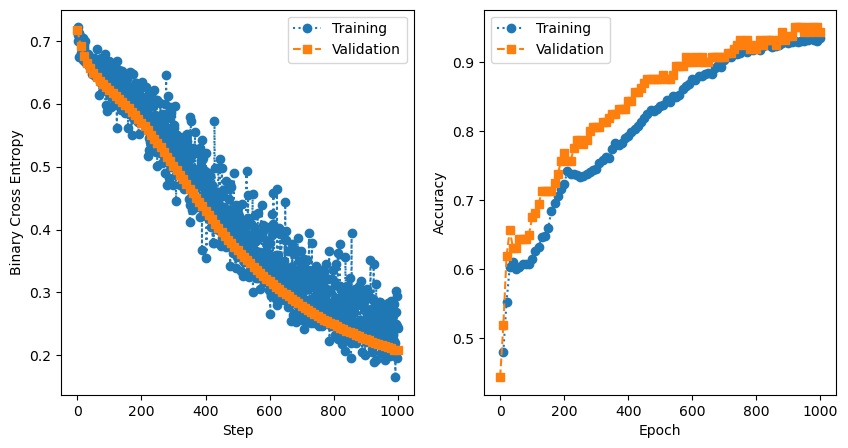

In [10]:
# prepare lists for plotting
train_loss_step_list = []
train_loss_list = []

train_acc_step_list = []
train_acc_list = []

val_step_list = []
val_loss_list = []
val_acc_list = []

step = 0

max_epochs = 100
threshold = 0.5

for epoch in range(0, max_epochs + 1):

    if epoch > 0:
        # training

        train_total = 0
        train_correct = 0

        model.train()
        for x, t in train_loader:
            y_logits = model(x).squeeze()
            loss = criterion(input=y_logits, target=t.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            step += 1

            y_score = y_logits.sigmoid()
            y_pred = y_score >= threshold
            train_total += len(x)
            train_correct += (y_pred == t).sum().item()

            train_loss_step_list.append(step)
            train_loss_list.append(loss.item())

        train_acc_step_list.append(step)
        train_acc_list.append(train_correct / train_total)
    
    # validation
    val_loss_sum = 0
    val_total = 0
    val_correct = 0
    
    model.eval()
    with torch.inference_mode(): # disable gradient computation for validation
        for x, t in val_loader:
            y_logits = model(x).squeeze()
            y_score = y_logits.sigmoid()
            y_pred = y_score >= threshold
            loss = criterion(input=y_logits, target=t.float())

            val_total += len(x)
            val_loss_sum += loss.item() * len(x)
            val_correct += (y_pred == t).sum().item()

    val_step_list.append(step)
    val_loss_list.append(val_loss_sum / val_total)
    val_acc_list.append(val_correct / val_total)

    plot_curve(train_loss_step_list, train_loss_list, train_acc_step_list, train_acc_list, val_step_list, val_loss_list, val_acc_list)

## 4. Testing

In [11]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

In [12]:
# scikit-learn notation
y_score_arr = []
y_true_arr = []

model.eval()
with torch.inference_mode(): # disable gradient computation for validation
    for x, t in test_loader:
        y_logits = model(x).squeeze()
        y_score = y_logits.sigmoid()
        y_pred = y_score >= threshold

        y_score_arr.append(y_score.numpy())
        y_true_arr.append(t.numpy())

y_score_arr = np.concatenate(y_score_arr)
y_true_arr = np.concatenate(y_true_arr)

In [13]:
fpr, tpr, threshold_arr = metrics.roc_curve(
    y_true=y_true_arr,
    y_score=y_score_arr,
)

In [14]:
tnr = 1 - fpr

In [15]:
roc_auc = metrics.auc(tpr, tnr)

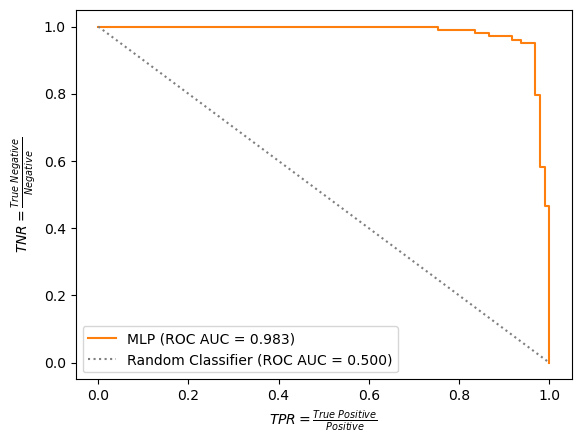

In [16]:
fig, ax = plt.subplots()
ax.plot(tpr, tnr, label=f'MLP (ROC AUC = {roc_auc:.3f})', color='tab:orange')
ax.plot([0, 1], [1, 0], label='Random Classifier (ROC AUC = 0.500)', color='tab:gray', ls=':')
ax.set_xlabel(r'$TPR=\frac{True\ Positive}{Positive}$')
ax.set_ylabel(r'$TNR=\frac{True\ Negative}{Negative}$')
ax.legend()